偵測到電腦核心數 = 16
522729 OD pairs
723 zones
10107 nodes
25286 links
Reading the network data took 6.86 secs
==== 開始交通指派 ====
Iteration 1 no improvement in gap: inf count: 1
    Iteration 1 completed :)


C:\Users\Allen\AppData\Local\Temp\ipykernel_8316\1982321822.py:190: RuntimeWarning: invalid value encountered in power
  tmpCost = linkSet[l].fft * (1 + linkSet[l].alpha * ((tmpFlow / linkSet[l].capacity) ** linkSet[l].beta))
c:\Users\Allen\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 2 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 3 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 4 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 5 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 6 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 7 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 8 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 9 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 10 completed :)
Iteration 11 no improvement in gap: 0.0325 count: 1
    Iteration 11 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 12 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 13 no improvement in gap: 0.07102 count: 1
    Iteration 13 completed :)
    Iteration 14 completed :)
Iteration 15 no improvement in gap: 0.01159 count: 1
    Iteration 15 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 16 no improvement in gap: 0.0473 count: 2
    It

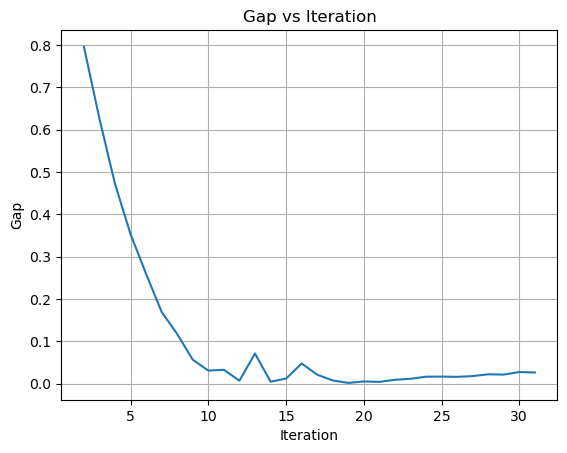

----------找到 min_gap iteration =  19 。重新開始指派-----------
==== 開始交通指派 ====
Iteration 1 no improvement in gap: inf count: 1
    Iteration 1 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 2 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 3 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 4 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 5 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 6 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 7 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 8 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 9 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 10 completed :)
Iteration 11 no improvement in gap: 0.0325 count: 1
    Iteration 11 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
    Iteration 12 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 13 no improvement in gap: 0.07102 count: 1
    Iteration 13 completed :)
    Iteration 14 completed :)
Iteration 15 no improv

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 28 21:09:46 2017 (modified for performance)
Author: Pramesh Kumar (original)
        Modified by ChatGPT (2025-04-15)

效能改進措施：
 1. 平行化 AON 分配（loadAON_parallel）
 2. 程式內部部分小幅向量化與簡化（例如 updateTravelTime）
 3. 後續可考慮用 numba 進行 JIT 加速（目前未做大幅調整）
"""

import math
import time
import heapq
import numpy as np
from scipy import optimize
from scipy.optimize import fsolve
import copy
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt

inputLocation = "Taipei/"

# 動態偵測可用 CPU 核心數
import os
CPU_COUNT = os.cpu_count() or 1
print(f"偵測到電腦核心數 = {CPU_COUNT}")

# -------------------------------
# 基本資料結構與初始化
# -------------------------------
class Zone:
    def __init__(self, _tmpIn):
        self.zoneId = _tmpIn[0]
        self.lat = 0
        self.lon = 0
        self.destList = []


class Node:
    '''
    此類別儲存網絡中節點的資訊
    '''
    def __init__(self, _tmpIn):
        self.Id = _tmpIn[0]
        self.lat = 0
        self.lon = 0
        self.outLinks = []
        self.inLinks = []
        self.label = float("inf")
        self.pred = ""
        self.inDegree = 0
        self.outDegree = 0
        self.order = 0  # 拓樸排序順序
        self.wi = 0.0  # Dial 演算法中節點權重
        self.xi = 0.0  # Dial 演算法中節點流量
        self.xj = 0.0  # 新增：用於流量回溯時累計需求


class Link:
    '''
    此類別儲存網絡中連結的資訊
    '''
    def __init__(self, _tmpIn):
        self.tailNode = _tmpIn[0]
        self.headNode = _tmpIn[1]
        self.capacity = float(_tmpIn[2])  # veh per hour
        self.length = float(_tmpIn[3])      # Length
        self.fft = float(_tmpIn[4])         # Free flow travel time (min)
        self.beta = float(_tmpIn[6])
        self.alpha = float(_tmpIn[5])
        self.speedLimit = float(_tmpIn[7])
        #self.toll = float(_tmpIn[9])
        #self.linkType = float(_tmpIn[10])
        self.flow = 0.0
        self.cost = float(_tmpIn[4])
        self.logLike = 0.0
        self.reasonable = True  # 用於 Dial 隨機分配
        self.wij = 0.0  # Dial 演算法中連結權重
        self.xij = 0.0  # Dial 演算法中該連結上流量累計


class Demand:
    def __init__(self, _tmpIn):
        self.fromZone = _tmpIn[0]
        self.toNode = _tmpIn[1]
        self.demand = float(_tmpIn[2])


def readDemand():
    inFile = open(inputLocation + "demand.dat")
    tmpIn = inFile.readline().strip().split("\t")
    for x in inFile:
        tmpIn = x.strip().split("\t")
        tripSet[tmpIn[0], tmpIn[1]] = Demand(tmpIn)
        if tmpIn[0] not in zoneSet:
            zoneSet[tmpIn[0]] = Zone([tmpIn[0]])
        if tmpIn[1] not in zoneSet:
            zoneSet[tmpIn[1]] = Zone([tmpIn[1]])
        if tmpIn[1] not in zoneSet[tmpIn[0]].destList:
            zoneSet[tmpIn[0]].destList.append(tmpIn[1])
    inFile.close()
    print(len(tripSet), "OD pairs")
    print(len(zoneSet), "zones")


def readNetwork():
    inFile = open(inputLocation + "network.dat")
    tmpIn = inFile.readline().strip().split("\t")
    for x in inFile:
        tmpIn = x.strip().split("\t")
        linkSet[tmpIn[0], tmpIn[1]] = Link(tmpIn)
        if tmpIn[0] not in nodeSet:
            nodeSet[tmpIn[0]] = Node(tmpIn[0])
        if tmpIn[1] not in nodeSet:
            nodeSet[tmpIn[1]] = Node(tmpIn[1])
        if tmpIn[1] not in nodeSet[tmpIn[0]].outLinks:
            nodeSet[tmpIn[0]].outLinks.append(tmpIn[1])
        if tmpIn[0] not in nodeSet[tmpIn[1]].inLinks:
            nodeSet[tmpIn[1]].inLinks.append(tmpIn[0])
    inFile.close()
    print(len(nodeSet), "nodes")
    print(len(linkSet), "links")


# -------------------------------
# 初始讀取
# -------------------------------
readStart = time.time()

tripSet = {}
zoneSet = {}
linkSet = {}
nodeSet = {}

readDemand()
readNetwork()

originZones = set([k[0] for k in tripSet])
print("Reading the network data took", round(time.time() - readStart, 2), "secs")

# -------------------------------
# Dijkstra 及相關函數（原始版本改為局部版本）
# -------------------------------
def DijkstraHeap(origin):
    """
    計算從 origin 到所有節點的最短路徑，
    直接更新 global nodeSet（用於 deterministic loading）
    """
    for n in nodeSet:
        nodeSet[n].label = float("inf")
        nodeSet[n].pred = ""
    nodeSet[origin].label = 0.0
    nodeSet[origin].pred = "NA"
    SE = [(0, origin)]
    while SE:
        currentNode = heapq.heappop(SE)[1]
        currentLabel = nodeSet[currentNode].label
        for toNode in nodeSet[currentNode].outLinks:
            link = (currentNode, toNode)
            newNode = toNode
            newPred = currentNode
            existingLabel = nodeSet[newNode].label
            newLabel = currentLabel + linkSet[link].cost
            if newLabel < existingLabel:
                heapq.heappush(SE, (newLabel, newNode))
                nodeSet[newNode].label = newLabel
                nodeSet[newNode].pred = newPred


def updateTravelTime():
    """
    更新連結的 travel time，使用 BPR 公式
    """
    for l in linkSet:
        ratio = linkSet[l].flow / linkSet[l].capacity
        linkSet[l].cost = linkSet[l].fft * (1 + linkSet[l].alpha * (ratio ** linkSet[l].beta))


def findAlpha(x_bar):
    """
    使用非約束最佳化找出 Frank-Wolfe 演算法中的步長，
    如果 fsolve 失敗，則使用 fallback 固定步長
    """
    def df(alpha):
        sum_derivative = 0
        for l in linkSet:
            tmpFlow = linkSet[l].flow + alpha * (x_bar[l] - linkSet[l].flow)
            tmpCost = linkSet[l].fft * (1 + linkSet[l].alpha * ((tmpFlow / linkSet[l].capacity) ** linkSet[l].beta))
            sum_derivative += (x_bar[l] - linkSet[l].flow) * tmpCost
        return sum_derivative
    sol = optimize.root(df, np.array([0.1]))
    sol2 = fsolve(df, np.array([0.1]))
    if not sol.success or not (0 < sol2[0] <= 1):
        print("fsolve 無法找到有效步長，改用 fallback 步長")
        return 0.2
    return max(0.1, min(1, sol2[0]))


def tracePreds(dest):
    """
    回溯獲取從起點至 dest 的最短路徑
    """
    prevNode = nodeSet[dest].pred
    spLinks = []
    visited = set()
    while nodeSet[dest].pred != "NA":
        if dest in visited:
            print(f"循環偵測：{dest} 無法正確回溯")
            break
        visited.add(dest)
        spLinks.append((prevNode, dest))
        if prevNode == "":
            print(f"警告：節點 {dest} 的 pred 是空字串")
            break
        dest = prevNode
        prevNode = nodeSet[dest].pred
    return spLinks



def loadAON():
    """
    傳統 All-or-Nothing 分配：針對每個原點執行 Dijkstra，
    並根據最短路徑分配需求，回傳總的 SPTT 與輔助流量 x_bar
    """
    x_bar = {l: 0.0 for l in linkSet}
    SPTT = 0.0
    for r in originZones:
        DijkstraHeap(r)
        for s in zoneSet[r].destList:
            try:
                dem = tripSet[r, s].demand
            except KeyError:
                dem = 0.0
            SPTT += nodeSet[s].label * dem
            if r != s:
                for spLink in tracePreds(s):
                    x_bar[spLink] += dem
    return SPTT, x_bar


# -------------------------------
# 平行化 All-or-Nothing 分配（Performance Improvement）
# -------------------------------
def DijkstraHeap_local(origin, local_nodeSet, local_linkSet):
    """
    局部版本的 Dijkstra，操作拷貝後的資料
    """
    for n in local_nodeSet:
        local_nodeSet[n].label = float("inf")
        local_nodeSet[n].pred = ""
    local_nodeSet[origin].label = 0.0
    local_nodeSet[origin].pred = "NA"
    SE = [(0, origin)]
    while SE:
        currentNode = heapq.heappop(SE)[1]
        currentLabel = local_nodeSet[currentNode].label
        for toNode in local_nodeSet[currentNode].outLinks:
            link = (currentNode, toNode)
            newNode = toNode
            newPred = currentNode
            existingLabel = local_nodeSet[newNode].label
            newLabel = currentLabel + local_linkSet[link].cost
            if newLabel < existingLabel:
                heapq.heappush(SE, (newLabel, newNode))
                local_nodeSet[newNode].label = newLabel
                local_nodeSet[newNode].pred = newPred


def tracePreds_local(dest, local_nodeSet):
    """
    局部版本的回溯函數，用於平行運算中
    """
    spLinks = []
    visited = set()
    while local_nodeSet[dest].pred != "NA":
        if dest in visited:
            print(f"Local 循環偵測：{dest} 無法正確回溯")
            break
        visited.add(dest)
        pred = local_nodeSet[dest].pred
        spLinks.append((pred, dest))
        if pred == "":
            print(f"Local 警告：節點 {dest} 的 pred 是空字串")
            break
        dest = pred
    return spLinks


def compute_aon_for_origin(origin):
    """
    針對單一原點，利用深複製後的資料計算 AON 分配，
    回傳該原點的最短路徑總旅行時間（SPTT）與局部輔助流量字典
    """
    local_nodeSet = copy.deepcopy(nodeSet)
    local_linkSet = copy.deepcopy(linkSet)
    DijkstraHeap_local(origin, local_nodeSet, local_linkSet)
    local_SPTT = 0.0
    local_x_bar = {l: 0.0 for l in local_linkSet}
    for s in zoneSet[origin].destList:
        try:
            dem = tripSet[origin, s].demand
        except KeyError:
            dem = 0.0
        local_SPTT += local_nodeSet[s].label * dem
        if origin != s:
            spLinks = tracePreds_local(s, local_nodeSet)
            for link in spLinks:
                local_x_bar[link] += dem
    return local_SPTT, local_x_bar


def loadAON_parallel():
    """
    平行化版本的 All-or-Nothing 分配：
    將所有原點的 AON 分配平行計算後合併結果
    """
    global_origins = list(originZones)
    total_SPTT = 0.0
    total_x_bar = {l: 0.0 for l in linkSet}
    with ProcessPoolExecutor(max_workers= {CPU_COUNT}) as executor:
        futures = {executor.submit(compute_aon_for_origin, r): r for r in global_origins}
        for future in as_completed(futures):
            try:
                sptt, x_bar_partial = future.result()
                total_SPTT += sptt
                for l in x_bar_partial:
                    total_x_bar[l] += x_bar_partial[l]
            except Exception as exc:
                print(f"Origin {futures[future]} 發生例外: {exc}")
    return total_SPTT, total_x_bar


# -------------------------------
# Dial 演算法及交通指派
# -------------------------------
def findReasonableLinks():
    for l in linkSet:
        if nodeSet[l[1]].label > nodeSet[l[0]].label:
            linkSet[l].reasonable = True
        else:
            linkSet[l].reasonable = False


def computeLogLikelihood():
    for l in linkSet:
        if linkSet[l].reasonable:
            linkSet[l].logLike = math.exp(nodeSet[l[1]].label - nodeSet[l[0]].label - linkSet[l].cost)


def topologicalOrdering():
    for e in linkSet:
        if linkSet[e].reasonable:
            nodeSet[e[1]].inDegree += 1
    order = 0
    SEL = [k for k in nodeSet if nodeSet[k].inDegree == 0]
    while SEL:
        i = SEL.pop(0)
        order += 1
        nodeSet[i].order = order
        for j in nodeSet[i].outLinks:
            if linkSet[i, j].reasonable:
                nodeSet[j].inDegree -= 1
                if nodeSet[j].inDegree == 0:
                    SEL.append(j)
    if order < len(nodeSet):
        print("the network has cycle(s)")


def resetDialAttributes():
    for n in nodeSet:
        nodeSet[n].inDegree = 0
        nodeSet[n].outDegree = 0
        nodeSet[n].order = 0
        nodeSet[n].wi = 0.0
        nodeSet[n].xi = 0.0
        nodeSet[n].xj = 0.0
    for l in linkSet:
        linkSet[l].logLike = 0.0
        linkSet[l].reasonable = True
        linkSet[l].wij = 0.0
        linkSet[l].xij = 0.0


def DialLoad():
    """
    使用 Dial 演算法進行 stochastic loading
    """
    resetDialAttributes()
    x_bar = {l: 0.0 for l in linkSet}
    for r in originZones:
        DijkstraHeap(r)
        findReasonableLinks()
        topologicalOrdering()
        computeLogLikelihood()

        # 正向傳播：計算節點權重
        order = 1
        while order <= len(nodeSet):
            i = [k for k in nodeSet if nodeSet[k].order == order][0]
            if order == 1:
                nodeSet[i].wi = 1.0
            else:
                nodeSet[i].wi = sum([linkSet[k, i].wij for k in nodeSet[i].inLinks if linkSet[k, i].reasonable])
            for j in nodeSet[i].outLinks:
                if linkSet[i, j].reasonable:
                    linkSet[i, j].wij = nodeSet[i].wi * linkSet[i, j].logLike
            order += 1

        # 逆向回溯：分配流量
        order = len(nodeSet)
        while order >= 1:
            j = [k for k in nodeSet if nodeSet[k].order == order][0]
            try:
                dem = tripSet[r, j].demand
            except KeyError:
                dem = 0.0
            nodeSet[j].xj = dem + sum([linkSet[j, k].xij for k in nodeSet[j].outLinks if linkSet[j, k].reasonable])
            for i in nodeSet[j].inLinks:
                if linkSet[i, j].reasonable:
                    linkSet[i, j].xij = nodeSet[j].xj * (linkSet[i, j].wij / nodeSet[j].wi)
            order -= 1
        for l in linkSet:
            if linkSet[l].reasonable:
                x_bar[l] += linkSet[l].xij
    return x_bar

def assignment(loading, algorithm, accuracy, maxIter, allow, recal, parallel_loading=False):
    """
    執行交通指派：
      - loading: "deterministic" 或 "stochastic"
      - algorithm: "MSA" 或 "FW"
      - parallel_loading: 若 True 則使用平行化 deterministic loading
    """
    mingap = False
    it = 1
    count = 0
    current_min_gap = float("inf")
    gap = float("inf")
    x_bar = {l: 0.0 for l in linkSet}
    startP = time.time()
    gap_lst = []


    print("==== 開始交通指派 ====")
    while gap > accuracy:
        if algorithm == "MSA" or it < 2:
            alpha = 1.0 / it
        elif algorithm == "FW":
            alpha = findAlpha(x_bar)
        else:
            print("Terminating the program.....")
            print("The solution algorithm", algorithm, "does not exist!")
        prevLinkFlow = np.array([linkSet[l].flow for l in linkSet])
        for l in linkSet:
            linkSet[l].flow = alpha * x_bar[l] + (1 - alpha) * linkSet[l].flow
        updateTravelTime()
        if loading == "deterministic":
            SPTT, x_bar = loadAON()  # 或 loadAON_parallel() 根據需求選用
            TSTT = round(sum([linkSet[a].flow * linkSet[a].cost for a in linkSet]), 3)
            SPTT = round(SPTT, 3)
            if SPTT == 0:
                print("警告：SPTT 為 0，無法計算收斂 gap。將 gap 設為 0。")
                gap = 0
            else:
                gap = round(abs((TSTT / SPTT) - 1), 5)
            if it == 1:
                gap = gap + float("inf")
        elif loading == "stochastic":
            x_bar = DialLoad()
            currentLinkFlow = np.array([linkSet[l].flow for l in linkSet])
            change = prevLinkFlow - currentLinkFlow
            if it < 3:
                gap = gap + float("inf")
            else:
                gap = round(np.linalg.norm(np.divide(change, prevLinkFlow, out=np.zeros_like(change), where=prevLinkFlow != 0)), 2)
        else:
            print("Terminating the program.....")
            print("The loading", loading, "is unknown")
        
        gap_lst.append(gap)


        # save the current smallest gap
        if gap < current_min_gap:
            current_min_gap = gap
            min_gap_it = it
            count = 0

        elif gap >= current_min_gap:
            # if more than 10 iterations without improvement, stop the assignment
            if count > allow:
                print("The assignment did not converge: no improvement in", allow, "iterations, current gap:", gap)
                mingap = True
                break
            count += 1
            print("Iteration", it, "no improvement in gap:", gap, "count:", count)
        
        if it >= maxIter:
            print("The assignment did not converge: max iterations reached, current gap:", gap)
            break

        print(f"    Iteration {it} completed :)")

        it += 1

    print("Assignment took", time.time() - startP, "seconds")
    print("Assignment stopped in", it, "iterations, current gap:", gap)
    #from gap_lst find the minimum gap and its iteration
    min_gap = min(gap_lst)
    min_gap_it = gap_lst.index(min_gap) + 1 # +1 because iteration starts from 1
    print("Minimum gap found at iteration", min_gap_it, "with gap", min_gap)

    if recal == False:
        #plot gap_lst
        plt.plot(range(1, len(gap_lst) + 1), gap_lst)
        plt.xlabel("Iteration")
        plt.ylabel("Gap")
        plt.title("Gap vs Iteration")
        plt.grid()
        plt.savefig("gap_vs_iteration.png")
        plt.show()

    return min_gap_it, mingap
    

def writeUEresults():
    outFile = open("UE_results.dat", "w")
    tmpOut = "tailNode\theadNode\tcapacity\tlength\tfft\tUE_travelTime\tUE_flow"
    outFile.write(tmpOut + "\n")
    for i in linkSet:
        tmpOut = f"{linkSet[i].tailNode}\t{linkSet[i].headNode}\t{linkSet[i].capacity}\t{linkSet[i].length}\t{linkSet[i].fft}\t{linkSet[i].cost}\t{linkSet[i].flow}"
        outFile.write(tmpOut + "\n")
    outFile.close()

# -------------------------------
# 健康檢查：輸出網絡狀態
# -------------------------------
def checkNetworkHealth():
    print("==== Network Health Check ====")
    isolated = [n for n in nodeSet if len(nodeSet[n].inLinks) == 0 and len(nodeSet[n].outLinks) == 0]
    print(f"完全孤立節點: {len(isolated)}")
    unreachable = [node for node in nodeSet if nodeSet[node].pred == ""]
    print(f"目前未標定 predecessor 的節點數: {len(unreachable)}")
    allFlowZero = all(linkSet[l].flow == 0.0 for l in linkSet)
    print("所有流量皆為 0？", allFlowZero)


# -------------------------------
#三個可調整參數：accuracy, maxIter, allow(繼續迭代幾次 gap沒有改善就停)
# -------------------------------
min_gap_it, mingap = assignment("deterministic", "FW", accuracy = 0.001, maxIter = 100, allow = 10, recal=False, parallel_loading=True)


if mingap == True: #已知最佳迭代次數，進行二次指派
    print("----------找到 min_gap iteration = ", min_gap_it,"。重新開始指派-----------")
    assignment("deterministic", "FW", accuracy=0.00001, maxIter=min_gap_it, allow=10000, recal=True, parallel_loading=True)
writeUEresults()
checkNetworkHealth()

In [13]:
import pandas as pd

#open 校估.xlsx
#for sheet 1: link, AM, PM, A, B
#it stands for link name, AM flow, PM flow, A node, B node
#for sheet 2: link, AM, PM, A1, B1, A2, B2
#it stands for link name, AM flow, PM flow, A1 node, B1 node, A2 node, B2 node

#open UE_results.dat
#use (A, B) as key to find the corresponding link name in 校估.xlsx and compare AM flow with UE_flow

df= pd.read_excel("校估.xlsx", sheet_name=None)
sheet1 = df["工作表1"]
sheet2 = df["工作表2"]

ue_results = pd.read_csv("UE_results.dat", sep="\t")
ue_results.rename(columns={"tailNode": "A", "headNode": "B"}, inplace=True)

ue_results["link_name"] = ue_results.apply(lambda row: f"{int(row['A'])}_{int(row['B'])}", axis=1)
sheet1["link_name"] = sheet1.apply(lambda row: f"{row['A']}_{row['B']}", axis=1)

#look up UE_flow in ue_results to add a new column to sheet1 and sheet2
sheet1 = sheet1.merge(ue_results[["link_name", "UE_flow", "capacity"]], on="link_name", how="left")
#reserve the link,AM,UE_flow
sheet1 = sheet1[["link", "AM", "UE_flow", "capacity"]]
#calculate the difference percentage
sheet1["diff"] = (-sheet1["AM"] + sheet1["UE_flow"]) / sheet1["AM"] * 100
sheet1["diff"] = sheet1["diff"].round(2)
sheet1["diff"] = sheet1["diff"].astype(str) + "%"

#for sheet2, we need to find the corresponding link name for A1, B1 and A2, B2
#that is, there are two link to be found for each row in sheet2
#then we need to add up the two link's UE_flow to get the total flow for this row
#so that we can compare with AM flow
sheet2["link_name1"] = sheet2.apply(lambda row: f"{int(row['A1'])}_{int(row['B1'])}", axis=1)
sheet2["link_name2"] = sheet2.apply(lambda row: f"{int(row['A2'])}_{int(row['B2'])}", axis=1)
sheet2 = sheet2.merge(ue_results[["link_name", "UE_flow", "capacity"]], left_on="link_name1", right_on="link_name", how="left")
sheet2 = sheet2.merge(ue_results[["link_name", "UE_flow", "capacity"]], left_on="link_name2", right_on="link_name", how="left", suffixes=('_1', '_2'))
#calculate the total flow and capacity for this row
sheet2["UE_flow"] = sheet2["UE_flow_1"] + sheet2["UE_flow_2"]
sheet2["capacity"] = sheet2["capacity_1"] + sheet2["capacity_2"]
#calculate the difference percentage
sheet2["diff"] = (-sheet2["AM"] + sheet2["UE_flow"]) / sheet2["AM"] * 100
sheet2["diff"] = sheet2["diff"].round(2)
sheet2["diff"] = sheet2["diff"].astype(str) + "%"
#reserve the link,AM,UE_flow
sheet2 = sheet2[["link", "AM", "UE_flow", "capacity", "diff"]]

#now,we can combine the two sheets
sheet1 = pd.concat([sheet1, sheet2], ignore_index=True)

#calculate the mape for the whole data from diff
sheet1["diff_abs"] = sheet1["diff"].str.replace("%", "").astype(float).abs()
#V/C ratio = UE_flow / capacity
sheet1["V/C"] = sheet1["UE_flow"] / sheet1["capacity"]
#GEH = (2(UE_flow - AM)^2 / (UE_flow + AM))^0.5
sheet1["GEH"] = (2 * (sheet1["UE_flow"] - sheet1["AM"]) ** 2 / (sheet1["UE_flow"] + sheet1["AM"])) ** 0.5
#average the diff_abs and print the result
mape = sheet1["diff_abs"].mean()
#round the UE_flow, V/C and capacity to int
sheet1["capacity"] = sheet1["capacity"].round(0).astype(int)
sheet1["UE_flow"] = sheet1["UE_flow"].round(0).astype(int)
sheet1["V/C"] = sheet1["V/C"].round(2)
print("MAPE: ", mape.round(2), "%")

sheet1[["link", "capacity", "AM", "UE_flow", "V/C", "diff", "GEH"]]

MAPE:  32.19 %


,link,capacity,AM,UE_flow,V/C,diff,GEH
0,民權路(關渡站前)進城,5240,6326,4745,0.91,-24.99%,21.245479
1,民權路(關渡站前)出城,5240,4236,3269,0.62,-22.84%,15.791704
2,大度路出城,5880,3967,3173,0.54,-20.02%,13.293942
3,大度路進城,5880,5018,4260,0.72,-15.1%,11.127266
4,重陽橋進城,3920,5480,5895,1.50,7.57%,5.502031
5,重陽橋出城,3920,2370,3114,0.79,31.38%,14.202527
6,臺北橋進城,5880,7719,2297,0.39,-70.25%,76.624705
7,臺北橋出城,5880,2041,1216,0.21,-40.44%,20.452323
8,忠孝橋進城,5880,7570,6697,1.14,-11.53%,10.338354
9,忠孝橋出城,5880,3521,2669,0.45,-24.21%,15.323141
